<a href="https://colab.research.google.com/github/JoonghoonChoi/AI_01_Projects/blob/main/AI_01_%EC%B5%9C%EC%A4%91%ED%9B%88_Project_Section_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1. Project
  *Codestates_AI_01_Joonghoon Choi*


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_data/vgames2.csv')
data.drop(columns = 'Unnamed: 0', inplace = True)
print(data.dtypes)
print(data.shape)
data

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object
(16598, 9)


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


In [ ]:
#####Preprocessing#####

data.isna().sum() #Year : 271, Genre : 50, Publisher : 58 결측치 확인

#하나하나 검색해서 채우기엔 너무 비효율적이라고 판단
#year, genre를 주변 데이터를 사용해 대체하는 것이 의미없다고 판단. 삭제  #플랫폼으로 sort 하고 출시연도를 바로 위아래 값으로 대체할 수 있을까 ??
#publisher는 결측치가 있어도 분석 결과에 영향을 미치지 않는다고 판단. 제거하지 않음
data.dropna(subset = ['Year', 'Genre'], inplace = True) 

#Year_2 column 추가 (전체 자료가 198x ~ 20xx 이므로 뒤 두자리만 표기)
data['Year_2'] = data['Year'].apply(int)
data['Year_2'] = data['Year_2'].astype(str).str[-2:].astype(int)

y_lst = [] #for loop, list 사용해서 Year 칼럼 내 value를 연도 뒤 두자리(~~**)로 적용
for y in data['Year_2'].values.tolist() :
  y = '%02d' %y  #print a 2 length integer including 0
  y_lst.append(y)

data['Year_2'] = y_lst

#Sales columns 전처리(단위 통일)
def sales_to_num(vals) : #k는 삭제하고 1/1000 곱해주기, m은 그냥 삭제 >> 전체 float 화
  if vals[-1:] == 'K' :
    vals = vals.replace('K', '')
    return float(vals) * 1/1000
  elif vals[-1:] == 'M' :
    return float(vals.replace('M',''))
  else :
    return float(vals)

data['NA_Sales(M)'] = data['NA_Sales'].apply(sales_to_num)
data['EU_Sales(M)'] = data['EU_Sales'].apply(sales_to_num)
data['JP_Sales(M)'] = data['JP_Sales'].apply(sales_to_num)
data['Other_Sales(M)'] = data['Other_Sales'].apply(sales_to_num)

df = data.drop(columns = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis = 1)
df = df.reset_index().drop(columns = 'index')

df.isna().sum()
df = df.fillna('Missing value')
df

,Name,Platform,Genre,Publisher,Year_2,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M)
0,Candace Kane's Candy Factory,DS,Action,Destineer,08,0.04,0.00,0.00,0.00
1,The Munchables,Wii,Action,Namco Bandai Games,09,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,Adventure,Alchemist,10,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,Misc,Zoo Games,10,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,Platform,D3Publisher,10,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...,...
16272,Ice Age 2: The Meltdown,GC,Platform,Vivendi Games,06,0.15,0.04,0.00,0.01
16273,Rainbow Islands: Revolution,PSP,Action,Rising Star Games,05,0.01,0.00,0.00,0.00
16274,NBA 2K16,PS3,Sports,Take-Two Interactive,15,0.44,0.19,0.03,0.13
16275,Toukiden: The Age of Demons,PSV,Action,Tecmo Koei,13,0.05,0.05,0.25,0.03


#Q1. 지역에 따라 선호하는 게임의 장르가 다를까?
- 지역은 매출 현황 데이터의 북미, 유럽, 일본, 기타 총 4개로 구분할 수 있음
- **장르 vs 지역별 매출** 에 대한 가설검정을 실시할 수 있음

  : *two sample X2 test 실시* (Genre Vs. Sales)
- 지역별 매출 평균을 사용한 시각화 차트


In [ ]:
#x2 test를 사용해서 지역과 장르간 연관성이 있는지 가설검정 테스트 실시
from scipy.stats import chi2_contingency

df_x_test = df[['NA_Sales(M)', 'EU_Sales(M)', 'JP_Sales(M)', 'Other_Sales(M)']].astype('category')
df_x_test['Genre'] = df['Genre']
df_x_test

,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),Genre
0,0.04,0.00,0.00,0.00,Action
1,0.17,0.00,0.00,0.01,Action
2,0.00,0.00,0.02,0.00,Adventure
3,0.04,0.00,0.00,0.00,Misc
4,0.12,0.09,0.00,0.04,Platform
...,...,...,...,...,...
16272,0.15,0.04,0.00,0.01,Platform
16273,0.01,0.00,0.00,0.00,Action
16274,0.44,0.19,0.03,0.13,Sports
16275,0.05,0.05,0.25,0.03,Action


In [ ]:
#귀무가설 : 각 지역 매출액과 장르 간 연관성이 없을 것이다.
#대안가설 : 각 지역 매출액과 장르 간 연관성이 있을 것이다.
NA_cross = pd.crosstab(df_x_test['Genre'], df_x_test['NA_Sales(M)'])
EU_cross = pd.crosstab(df_x_test['Genre'], df_x_test['EU_Sales(M)'])
JP_cross = pd.crosstab(df_x_test['Genre'], df_x_test['JP_Sales(M)'])
Other_cross = pd.crosstab(df_x_test['Genre'], df_x_test['Other_Sales(M)'])

chi_stat, pvalue, dof, ex = chi2_contingency(NA_cross, correction = False)
print(' North America\n', 'X2_stat :', chi_stat, 'P-value :', pvalue, '\n')
chi_stat, pvalue, dof, ex = chi2_contingency(EU_cross, correction = False)
print(' Europe\n', 'X2_stat :', chi_stat, 'P-value :', pvalue, '\n')
chi_stat, pvalue, dof, ex = chi2_contingency(JP_cross, correction = False)
print(' Japan\n', 'X2_stat :', chi_stat, 'P-value :', pvalue, '\n')
chi_stat, pvalue, dof, ex = chi2_contingency(Other_cross, correction = False)
print(' Other Countries\n', 'X2_stat :', chi_stat, 'P-value :', pvalue)

 North America
 X2_stat : 6233.655354090705 P-value : 7.549444125974192e-63 

 Europe
 X2_stat : 4477.935832640966 P-value : 6.8167487877648e-38 

 Japan
 X2_stat : 5219.175760673923 P-value : 5.08736657649697e-172 

 Other Countries
 X2_stat : 2285.5343815803913 P-value : 1.0672942341351104e-19


* 귀무가설 : 각 지역 매출액과 장르 간 연관성이 없을 것이다.
* 대안가설 : 각 지역 매출액과 장르 간 연관성이 있을 것이다.

  **two sample X2-test 결과**

 북미, 유럽, 일본, 기타 국가 모두 X2-test 결과 p-value 값이 0이므로 
 
 신뢰수준 95%에서 귀무가설 "지역 매출액과 장르 간 연관성이 없을 것이다"라는 귀무가설을 기각할 근거가 충분하다.


In [ ]:
#실제 데이터 이해를 돕기 위한 시각화 과정
#장르별 매출 평균액을 사용해서 df 생성
df_region_genre = pd.DataFrame({'Genre' : df['Genre'].values,
                                'NA' : df['NA_Sales(M)'].values,
                                'EU' : df['EU_Sales(M)'].values,
                                'JP' : df['JP_Sales(M)'].values,
                                'Other' : df['Other_Sales(M)']})
print(df_region_genre)
df_region_genre = df_region_genre.groupby('Genre').mean().reset_index()
df_region_genre

           Genre    NA    EU    JP  Other
0         Action  0.04  0.00  0.00   0.00
1         Action  0.17  0.00  0.00   0.01
2      Adventure  0.00  0.00  0.02   0.00
3           Misc  0.04  0.00  0.00   0.00
4       Platform  0.12  0.09  0.00   0.04
...          ...   ...   ...   ...    ...
16272   Platform  0.15  0.04  0.00   0.01
16273     Action  0.01  0.00  0.00   0.00
16274     Sports  0.44  0.19  0.03   0.13
16275     Action  0.05  0.05  0.25   0.03
16276   Fighting  0.00  0.00  0.16   0.01

[16277 rows x 5 columns]


,Genre,NA,EU,JP,Other
0,Action,0.264892,0.158433,0.048307,0.056752
1,Adventure,0.080252,0.050165,0.040858,0.013150
2,Fighting,0.263892,0.119641,0.104359,0.043293
3,Misc,0.234774,0.123284,0.061103,0.042663
4,Platform,0.509588,0.229577,0.149348,0.058867
5,Puzzle,0.214427,0.089030,0.099189,0.021940
6,Racing,0.290738,0.192648,0.046164,0.062713
7,Role-Playing,0.217435,0.124898,0.233922,0.038697
8,Shooter,0.448812,0.242367,0.029828,0.079578
9,Simulation,0.213698,0.133298,0.074841,0.036890


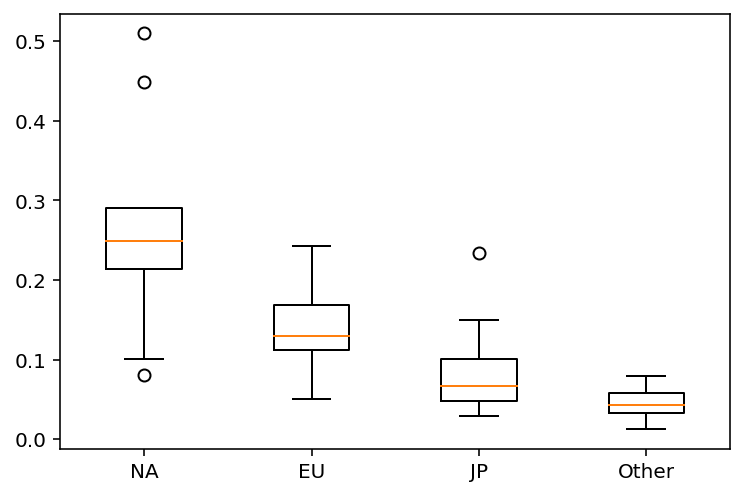

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#box plot 확인 결과, 지역별 매출액의 평균의 차가 상당히 큼. 그대로 사용할 수 없다고 판단
group1 = df_region_genre['NA']
group2 = df_region_genre['EU']
group3 = df_region_genre['JP']
group4 = df_region_genre['Other']
groups = [group1, group2, group3, group4]
plt.boxplot(groups)
plt.xticks([1, 2, 3, 4], ['NA', 'EU', 'JP', 'Other'])
plt.show();

In [ ]:
#지역별 각 장르의 매출 비중(%) 칼럼 생성
df_region_genre['NA(%)'] = df_region_genre.NA / df_region_genre.NA.sum() * 100
df_region_genre['EU(%)'] = df_region_genre.EU / df_region_genre.EU.sum() * 100
df_region_genre['JP(%)'] = df_region_genre.JP / df_region_genre.JP.sum() * 100
df_region_genre['Other(%)'] = df_region_genre.Other / df_region_genre.Other.sum() * 100
df_region_genre

,Genre,NA,EU,JP,Other,NA(%),EU(%),JP(%),Other(%)
0,Action,0.264892,0.158433,0.048307,0.056752,8.462797,9.365057,4.736782,10.730731
1,Adventure,0.080252,0.050165,0.040858,0.013150,2.563898,2.965299,4.006424,2.486342
2,Fighting,0.263892,0.119641,0.104359,0.043293,8.430854,7.072022,10.233118,8.185966
3,Misc,0.234774,0.123284,0.061103,0.042663,7.500589,7.287406,5.991518,8.066720
4,Platform,0.509588,0.229577,0.149348,0.058867,16.280371,13.570391,14.644543,11.130689
5,Puzzle,0.214427,0.089030,0.099189,0.021940,6.850529,5.262607,9.726110,4.148446
6,Racing,0.290738,0.192648,0.046164,0.062713,9.288517,11.387492,4.526679,11.857864
7,Role-Playing,0.217435,0.124898,0.233922,0.038697,6.946641,7.382764,22.937623,7.316896
8,Shooter,0.448812,0.242367,0.029828,0.079578,14.338706,14.326445,2.924845,15.046718
9,Simulation,0.213698,0.133298,0.074841,0.036890,6.827260,7.879311,7.338654,6.975288


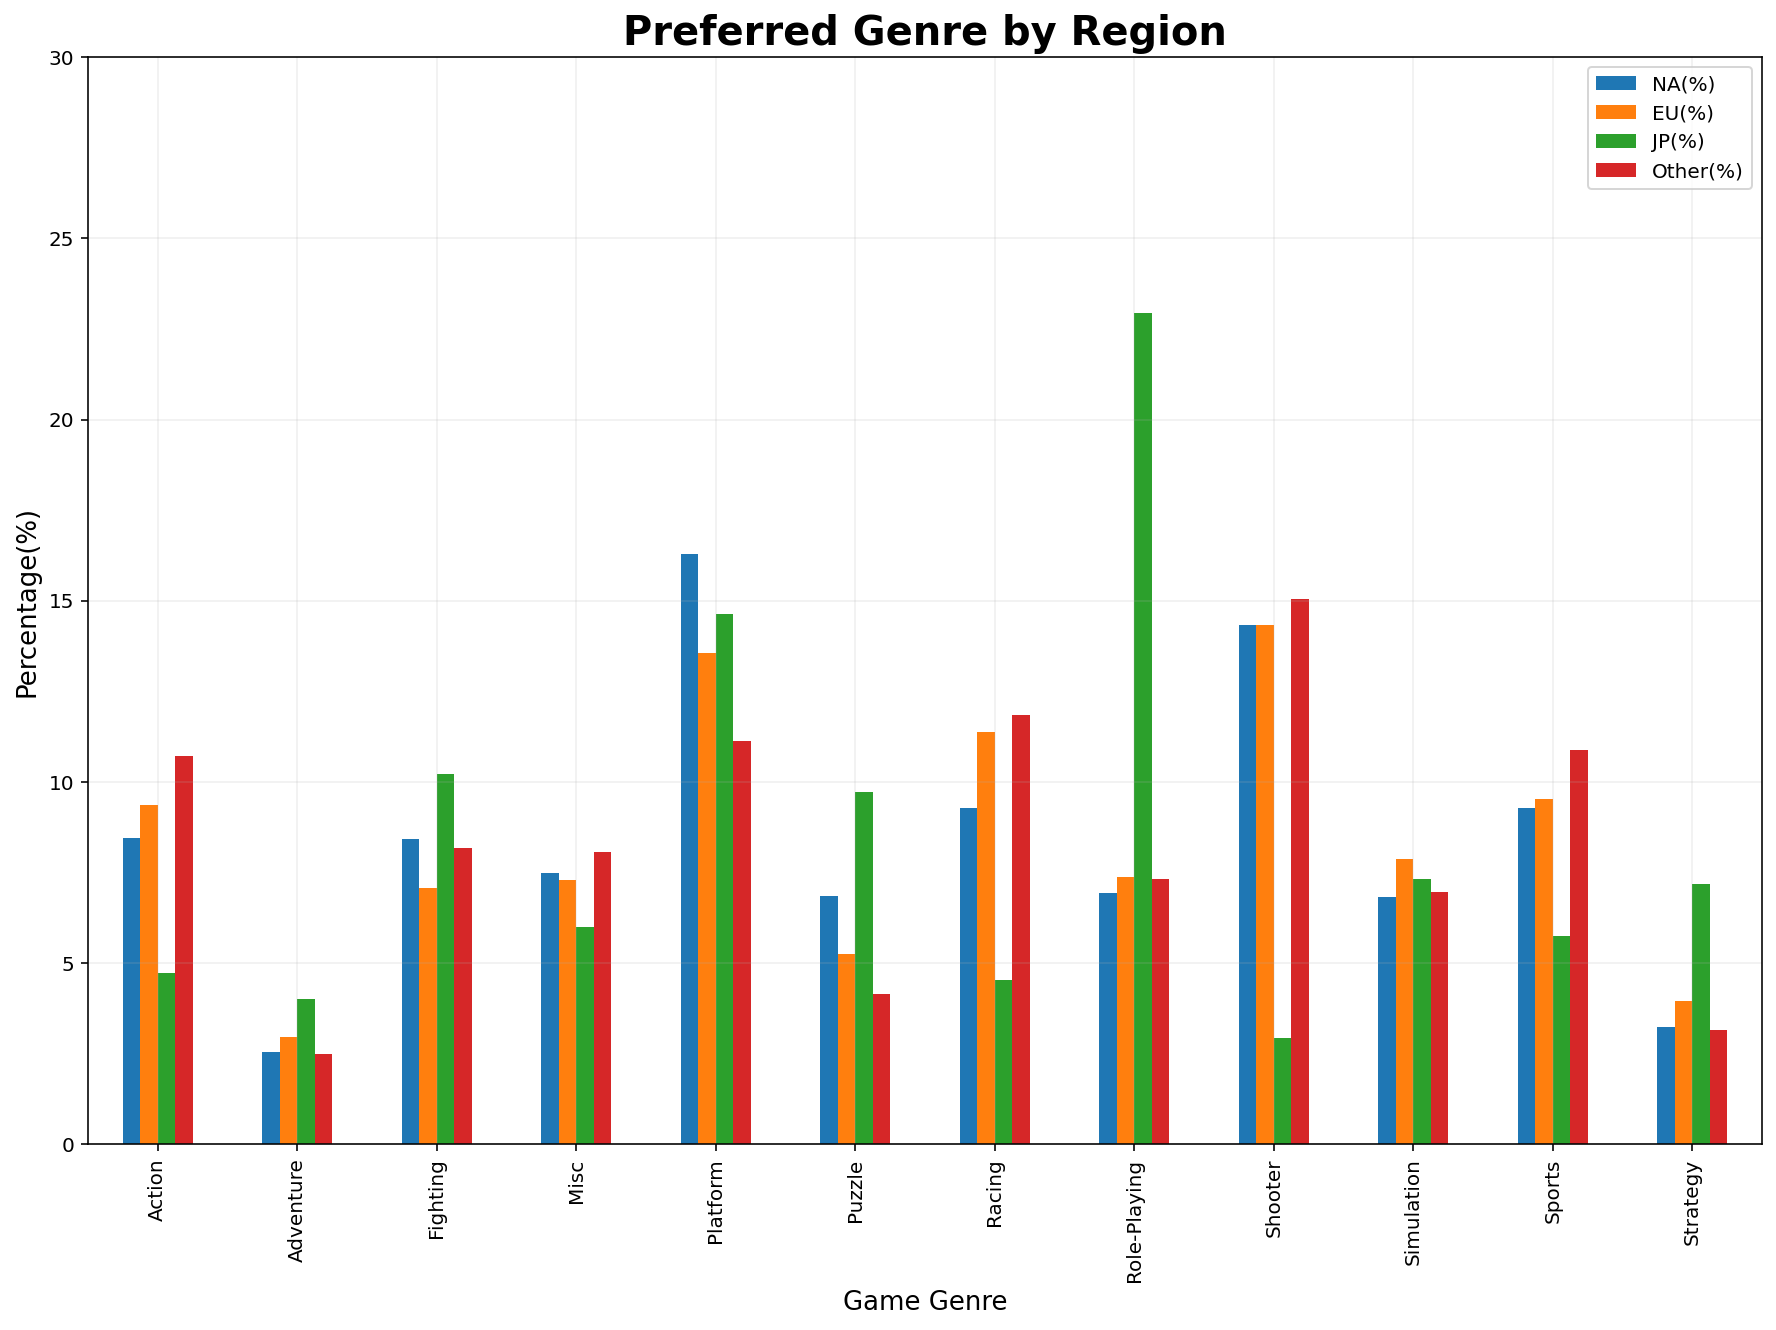

In [ ]:

df_r_g_for_graph = df_region_genre.drop(columns = ['NA', 'EU', 'JP', 'Other']).set_index('Genre')
df_r_g_for_graph.plot.bar(figsize = (15, 10))
plt.title('Preferred Genre by Region', fontsize = 20, weight = 'bold')
plt.xlabel('Game Genre', fontsize = 13)
plt.ylabel('Percentage(%)', fontsize = 13)
plt.ylim(0,30)
plt.grid(alpha = .2)
plt.show();

X2 test 실행 이후 이해를 돕기위한 시각화를 진행하였다.

지역별 매출 평균액을 시각화한 위 차트를 보면

* 지역에 상관없이 선호하는 장르 : Platform, Simulation

* 일본에서 유독 선호하는 장르 : RPG, Puzzle, Strategy

* 일본을 제외한 지역에서 선호하는 장르 : Shooter, Racing, Sports, Action

=> 일본과 나머지 지역들 간 선호하는(매출액 비중이 큰) 장르가 확연히 다른 것을 알 수 있다.

=> 고로 **"지역별 선호하는 장르가 다를까?"** 라는 질문에 그럴 가능성이 높다는 결론을 내릴 수 있다.

---

#Q2. 연도별 게임의 트렌드가 있을까?
- 게임 트렌드를 출시 트렌드로 해석
- 플랫폼, 장르 두 가지 요인으로 접근해 볼 수 있음
- **출시연도 Vs. 플랫폼, 장르** 가설검정

  : *two sample X2 test*
- 연도별 플랫폼, 장르 변화 시각화


In [ ]:
df_trend = df[['Year_2', 'Platform', 'Genre']]

#연도별 순차 정렬이 어려워 결국 앞 두자리도 추가해 줌
y_lst2 = []

for vals in df_trend['Year_2'] :
  if int(vals) > 70 :
    vals = '19' + vals
    y_lst2.append(vals)

  else :
    vals = '20' + vals
    y_lst2.append(vals)

a = pd.DataFrame({'Year' :y_lst2})
df_trend = df_trend.merge(a, how = 'outer', left_index = True, right_index = True)
df_trend.drop(columns = 'Year_2', inplace = True)
df_trend.sort_values('Year', inplace = True)
df_trend = df_trend.reset_index().drop(columns = 'index')
print(df_trend['Year'].unique()) #2018, 2019 값이 없다. 원래 없나? 결측치 삭제하면서 날아갔나?
df_trend

['1980' '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989'
 '1990' '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009'
 '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2020']


,Platform,Genre,Year
0,2600,Action,1980
1,2600,Misc,1980
2,2600,Fighting,1980
3,2600,Misc,1980
4,2600,Shooter,1980
...,...,...,...
16272,XOne,Action,2016
16273,PSV,Action,2017
16274,PSV,Role-Playing,2017
16275,PS4,Role-Playing,2017


In [ ]:
platform_cross = pd.crosstab(df_trend['Year'], df_trend['Platform'])
genre_cross = pd.crosstab(df_trend['Year'], df_trend['Genre'])

x2_stat, pvalue, dof, e = chi2_contingency(platform_cross, correction = False)
print(' Platfrom by Year :\n', 'X2 stat :', x2_stat, 'P value :', pvalue, '\n')
x2_stat, pvalue, dof, e = chi2_contingency(genre_cross, correction = False)
print(' Genre by Year :\n', 'X2 stat :', x2_stat, 'P value :', pvalue)

 Platfrom by Year :
 X2 stat : 75179.26670620928 P value : 0.0 

 Genre by Year :
 X2 stat : 2762.7998731892862 P value : 0.0


- 귀무가설 : 게임 출시연도와 플랫폼&장르 간 연관성이 없을 것이다.
- 대안가설 : 게임 출시연도와 플랫폼&장르 간 연관성이 있을 것이다.

  **two sample X2-test 결과**

 출시연도 Vs. 플랫폼, 장르 둘다 X2-test 결과 p-value 값이 0이므로 
 
 신뢰수준 95%에서 귀무가설 "게임 출시연도와 플랫폼&장르 간 연관성이 없을 것이다."라는 귀무가설을 기각할 근거가 충분하다.


In [ ]:
genre_cross.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980,1,0,1,4,0,0,0,0,2,0,0,0
1981,25,0,0,0,3,2,1,0,10,1,4,0
1982,18,0,0,1,5,3,2,0,5,0,2,0
1983,7,1,0,1,5,1,0,0,1,0,1,0
1984,1,0,0,1,1,3,3,0,3,0,2,0


In [ ]:
#시각화를 위해 연도별 데이터 표준화 실시
from sklearn.preprocessing import StandardScaler

genre_cross_t = genre_cross.transpose()
s_g = pd.DataFrame(StandardScaler().fit_transform(genre_cross_t), columns = genre_cross_t.columns, index = genre_cross_t.index)
s_g.head()

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020
Genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Action,0.282843,3.045467,3.083349,2.609949,-0.137361,0.593391,1.865992,0.508001,0.608164,0.375780,1.336306,0.800755,-1.399010,0.264135,-0.937826,-1.373552,-0.167031,0.716931,0.766399,0.742182,0.756849,1.072830,1.172907,1.898020,1.997116,2.475936,2.423340,2.271550,1.646342,2.243924,1.847422,2.429328,3.164180,2.772783,2.806853,3.135025,3.021668,1.260252,-0.301511
Adventure,-0.565685,-0.551541,-0.616670,-0.194772,-0.961524,-0.830747,-0.768350,-0.254000,-1.013606,-0.912608,-1.069045,-0.716465,0.225647,-1.056541,-0.937826,-0.703526,-0.440355,-1.045164,-0.512624,-0.607240,-0.702788,-0.825254,-0.581233,-1.253409,-0.784293,-0.789035,-0.308205,-0.322546,0.777401,0.324779,0.736686,0.207587,0.037759,0.394181,0.540957,0.032320,0.178401,-0.420084,-0.301511
Fighting,0.282843,-0.551541,-0.616670,-0.662226,-0.961524,-0.118678,-0.768350,0.508001,-1.013606,-0.912608,-1.069045,-1.222204,1.850304,1.584812,1.837112,1.440554,0.744049,0.405973,0.583681,-0.269884,0.000000,-0.907779,-0.309759,-0.489427,-0.784293,-0.767268,-0.694973,-1.022541,-1.009666,-0.974336,-0.982671,-0.768633,-0.385139,-0.687001,-0.520544,-0.464113,-0.490603,-0.420084,-0.301511
Misc,2.828427,-0.551541,-0.411113,-0.194772,-0.137361,-0.830747,-0.768350,-1.016001,-1.013606,-0.268414,-1.069045,-1.222204,-0.857458,-0.528271,-0.629500,0.502519,0.106293,-1.252469,-0.634436,-0.202413,-0.486546,-0.577678,-0.497702,-0.274556,0.703438,0.799918,0.610368,1.056854,1.498786,1.299114,1.451818,1.486771,-0.249207,-0.092351,-0.153101,-0.184870,-0.356802,-0.420084,-0.301511
Platform,-0.565685,-0.119900,0.411113,1.675042,-0.137361,2.017529,1.865992,0.508001,2.229933,1.019973,1.336306,1.306494,1.308752,1.584812,0.141316,-0.703526,-0.713679,-0.630553,-0.390813,-0.674711,-0.270303,0.123788,0.170541,0.537175,0.088940,0.081624,-0.719146,-1.187245,-0.927690,-1.343402,-1.119611,-0.970609,-0.641898,-0.227499,-0.785919,-0.572708,-0.624404,-0.420084,-0.301511


In [ ]:
platform_cross_t = platform_cross.transpose()
s_p = pd.DataFrame(StandardScaler().fit_transform(platform_cross_t), columns = platform_cross_t.columns, index = platform_cross_t.index)
s_p.head()

Year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020
Platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,5.477226,5.477226,5.477226,4.788584,0.238657,0.281463,0.393178,2.701477,0.771425,0.738798,-0.317846,-0.288218,-0.344917,-0.236864,-0.383057,-0.333409,-0.285956,-0.27235,-0.268564,-0.280342,-0.347648,-0.393546,-0.391386,-0.391662,-0.397712,-0.480036,-0.498496,-0.457654,-0.434430,-0.463592,-0.470079,-0.538879,-0.536559,-0.554097,-0.567000,-0.529575,-0.460452,-0.248282,-0.182574
3DO,-0.182574,-0.182574,-0.182574,-0.251253,-0.196541,-0.231793,-0.201384,-0.254257,-0.246200,-0.279101,-0.317846,-0.288218,-0.344917,-0.236864,-0.284919,-0.239019,-0.285956,-0.27235,-0.268564,-0.280342,-0.347648,-0.393546,-0.391386,-0.391662,-0.397712,-0.480036,-0.498496,-0.457654,-0.434430,-0.463592,-0.470079,-0.538879,-0.536559,-0.554097,-0.567000,-0.529575,-0.460452,-0.248282,-0.182574
3DS,-0.182574,-0.182574,-0.182574,-0.251253,-0.196541,-0.231793,-0.201384,-0.254257,-0.246200,-0.279101,-0.317846,-0.288218,-0.344917,-0.236864,-0.383057,-0.333409,-0.285956,-0.27235,-0.268564,-0.280342,-0.347648,-0.393546,-0.391386,-0.391662,-0.397712,-0.480036,-0.498496,-0.457654,-0.434430,-0.463592,-0.470079,1.166938,1.828730,2.282473,1.818881,1.781140,0.991846,-0.248282,-0.182574
DC,-0.182574,-0.182574,-0.182574,-0.251253,-0.196541,-0.231793,-0.201384,-0.254257,-0.246200,-0.279101,-0.317846,-0.288218,-0.344917,-0.236864,-0.383057,-0.333409,-0.285956,-0.27235,-0.113979,0.081767,0.271725,-0.190214,-0.376697,-0.391662,-0.397712,-0.480036,-0.498496,-0.445792,-0.424966,-0.463592,-0.470079,-0.538879,-0.536559,-0.554097,-0.567000,-0.529575,-0.460452,-0.248282,-0.182574
DS,-0.182574,-0.182574,-0.182574,-0.251253,-0.196541,0.281463,-0.201384,-0.254257,-0.246200,-0.279101,-0.317846,-0.288218,-0.344917,-0.236864,-0.383057,-0.333409,-0.285956,-0.27235,-0.268564,-0.280342,-0.347648,-0.393546,-0.391386,-0.391662,-0.024104,1.374160,2.607554,4.014425,4.202955,3.612314,3.315275,1.696329,0.099272,-0.270440,-0.536799,-0.529575,-0.460452,-0.248282,5.477226


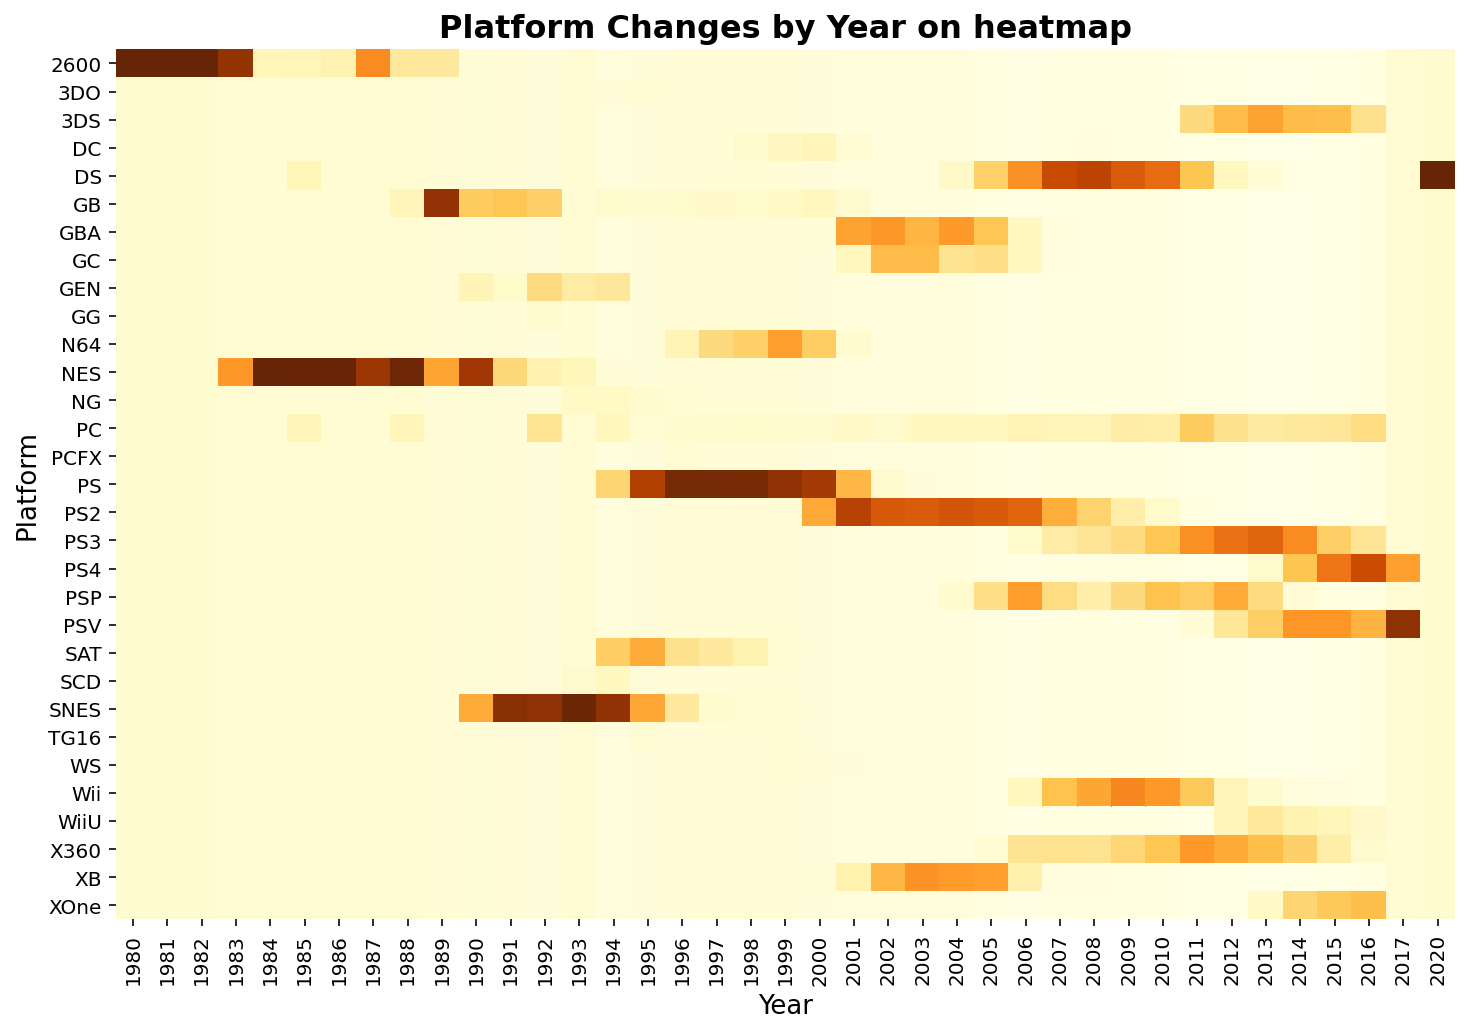

In [ ]:
import seaborn as sns

plt.figure(figsize = [12, 8] )
plt.title('Platform Changes by Year on heatmap', fontsize = 16, weight = 'bold')
plt.xlabel('Year', fontsize = 13)
plt.ylabel('Platform', fontsize = 13)
sns.heatmap(s_p, cmap = 'YlOrBr', cbar = False)
plt.show();

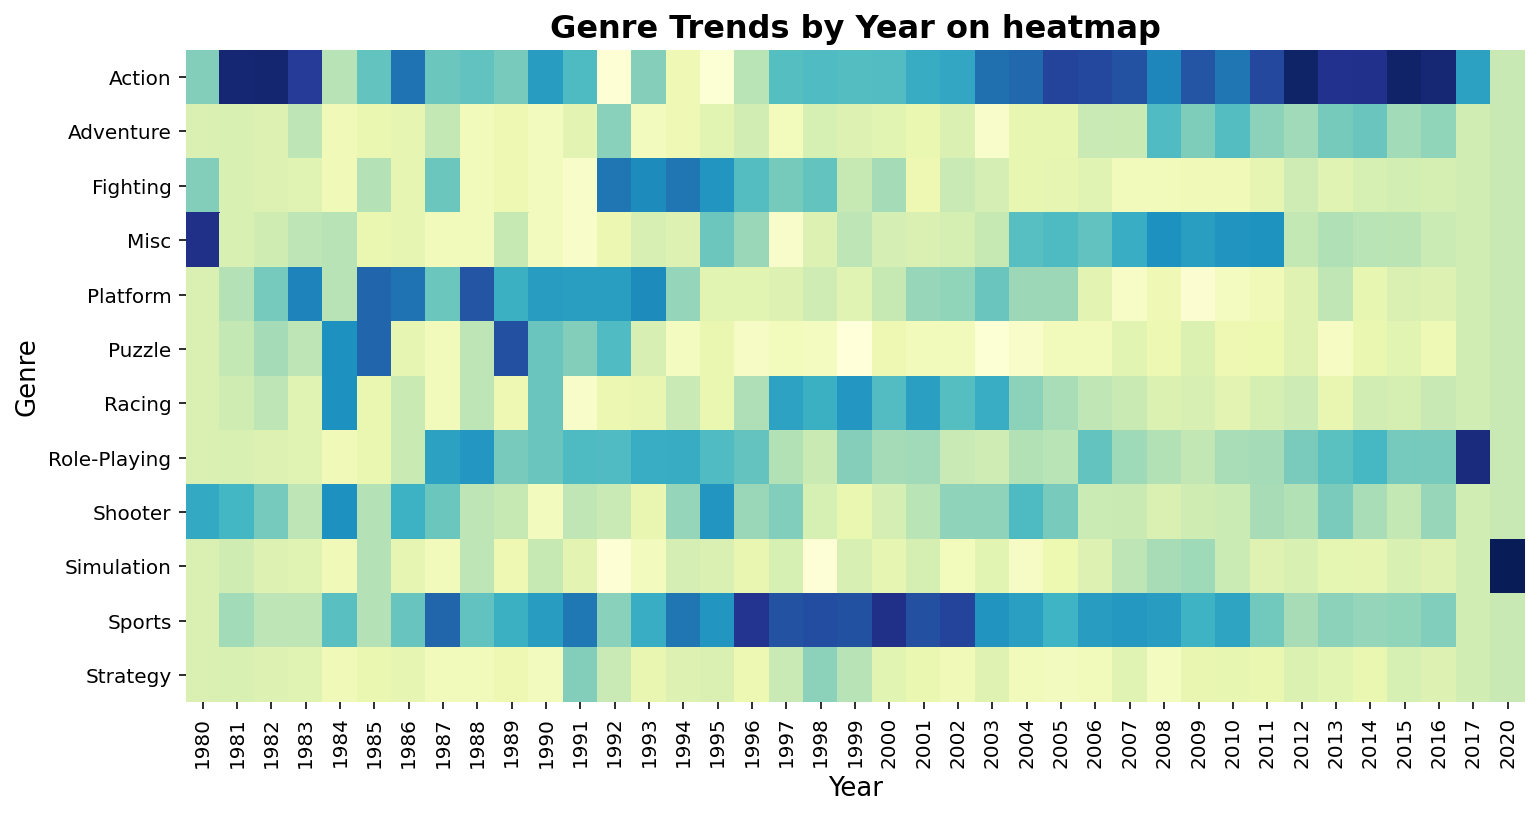

In [ ]:
plt.figure(figsize = [12, 6] )
plt.title('Genre Trends by Year on heatmap', fontsize = 16, weight = 'bold')
plt.xlabel('Year', fontsize = 13)
plt.ylabel('Genre', fontsize = 13)
sns.heatmap(s_g, cmap = 'YlGnBu', cbar = False)
plt.show();

X2 test 실행 이후 이해를 돕기위한 시각화를 진행하였다.

연도별 플랫폼, 장르의 비중 정도를 나타낸 위 히트맵 차트를 보면,

- **플랫폼**

  게임 시장 초창기(1980~)부터 아리타2600이 독점해오던 플랫폼 점유율이 1980년대 중반 닌텐도 출시, 1990년대 중반 플레이스테이션 출시, 2000년대 초반 xbox출시 등을 기점으로 현재는 플레이스테이션, 닌텐도, xbox 3강 브랜드에 PC까지 더해져 게임 시장에서 크게 4개의 플랫폼이 형성된 것으로 보인다.
  
  특히나 주목할 만한 점은 2010년대 들어서 고화질 게임을 플레이 할 수 있는 전통 콘솔(PS, X360, nintendo wii)의 여전한 강세와 함께 nintendo 3ds, psp, psv 등 휴대성을 필두로 한 휴대용 게임기 플랫폼의 점유율이 상당히 높아진 것을 확인할 수 있다.


- **장르**

  1980 ~ 1985 : action, shooter (아리타 2600 독점)

  1985 ~ 1990 : action, platform, sports (닌텐도 콘솔의 등장)
  
  1990 ~ 1995 : action, fighting, platform, rpg, sports (snes k.o.f 출시)
  
  1995 ~ 2000 : action, sports, racing (ps 플랫폼 등장)
  
  2000 ~ 2005 : action, racing, sports (ps2, gba, xone)

  2005 ~ 2010 : action, misc, sports (nintendo wii, ds, psp) 

  2010 ~ 2015 : action, adventure, rpg, sports (pc, x360)

  2015 ~ 2017 : action, adventure, rpg, sports, shooter (ps4, psv, xone)


- **결론**
  
  연도별 게임 플랫폼의 발달에 따른 게임 출시 트렌드가 존재한다.

  action 장르는 꾸준히 1990년대 초반을 제외하고 꾸준히 높게 출시되고 있는 반면

  sports 장르는 2000년대 초반 이후 약화되는 모습을 보인다.

  최근 트렌드로는 플랫폼의 성능이 올라감에 따라 고성능 게임(adventure, rpg, shooter 장르)의 출시 경향이 높아지는 모습을 볼 수 있다.




---



#Q3. 매출이 높은 게임에 대한 분석 및 시각화 프로세스
- 매출이 높은 게임을 판별하기 위해 whole sales 계산
- 분석 방향 :

  1. 매출이 높은 게임 top 30  선정
  2. 전체 매출액과 지역별 매출액 간 상관관계 분석
  3. 전체 매출액과 가장 상관관계가 높은 지역 선정 후 장르, 플랫폼 추가 분석 및 시각화
  

In [ ]:
# 총 매출액 top30 추출 및 df 생성
df['whole_sales'] = df['NA_Sales(M)'] + df['EU_Sales(M)'] + df['JP_Sales(M)'] + df['Other_Sales(M)']
df_top = df.sort_values('whole_sales', ascending = False).head(30).reset_index().drop(columns = 'index')
df_top

y_lst_top = []

for vals in df_top['Year_2'] :
  if int(vals) > 70 :
    vals = '19' + vals
    y_lst_top.append(vals)

  else :
    vals = '20' + vals
    y_lst_top.append(vals)

df_top['Year_2'] = y_lst_top
df_top = df_top.rename(columns = {'Year_2' : 'Year'})
df_top.head()

,Name,Platform,Genre,Publisher,Year,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales
0,Wii Sports,Wii,Sports,Nintendo,2006,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,Platform,Nintendo,1985,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,Racing,Nintendo,2008,15.85,12.88,3.79,3.31,35.83
3,Wii Sports Resort,Wii,Sports,Nintendo,2009,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,Role-Playing,Nintendo,1996,11.27,8.89,10.22,1.00,31.38


Correlation with NA :
[[1.         0.86823202]
 [0.86823202 1.        ]]


Correlation with EU :
[[1.         0.79915864]
 [0.79915864 1.        ]]


Correlation with JP :
[[1.         0.18778043]
 [0.18778043 1.        ]]


Correlation with Other :
[[1.         0.49718571]
 [0.49718571 1.        ]]


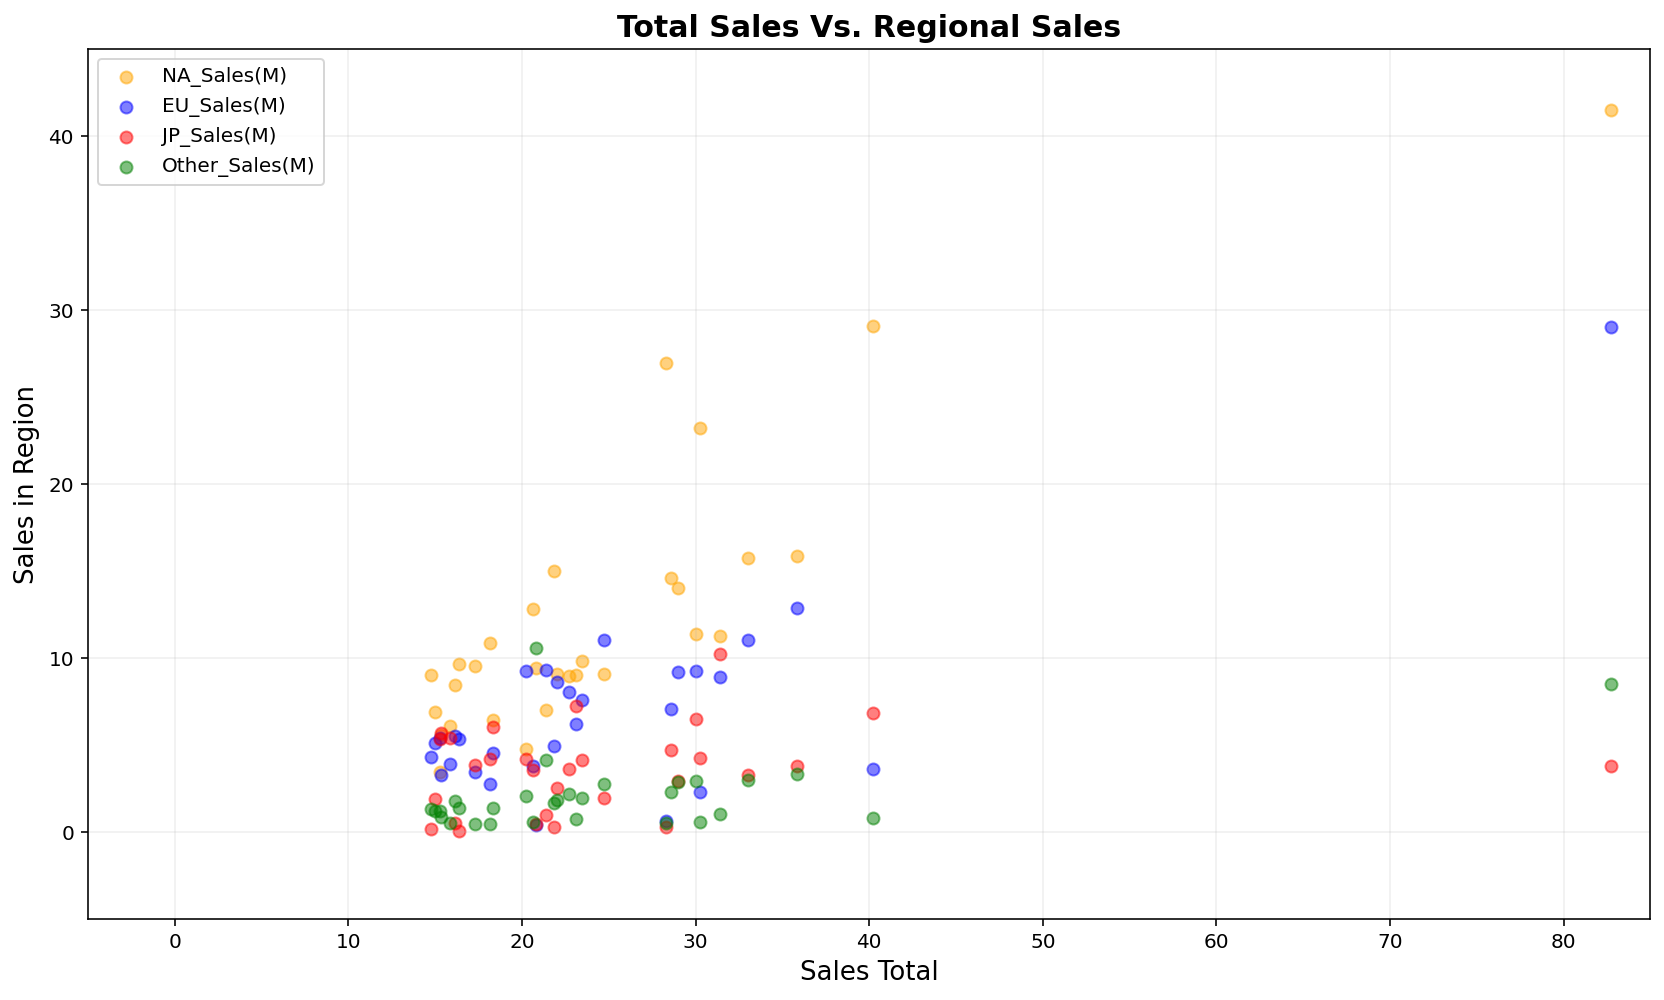

In [ ]:
#전체 매출액과 각 지역 매출액의 상관관계 분석
#어느 지역을 타겟으로 해야할 지 명확히 확인할 수 있을 것이라 판단

print('Correlation with NA :')
print(np.corrcoef(df_top['NA_Sales(M)'], df_top['whole_sales']))
print('\n')
print('Correlation with EU :')
print(np.corrcoef(df_top['EU_Sales(M)'], df_top['whole_sales']))
print('\n')
print('Correlation with JP :')
print(np.corrcoef(df_top['JP_Sales(M)'], df_top['whole_sales']))
print('\n')
print('Correlation with Other :')
print(np.corrcoef(df_top['Other_Sales(M)'], df_top['whole_sales']))

#scatter plot 시각화
fig, ax = plt.subplots(figsize = (14, 8))
ax.scatter(df_top['whole_sales'], df_top['NA_Sales(M)'], c = 'orange', alpha = .5)
ax.scatter(df_top['whole_sales'], df_top['EU_Sales(M)'], c = 'blue', alpha = .5)
ax.scatter(df_top['whole_sales'], df_top['JP_Sales(M)'], c = 'red', alpha = .5)
ax.scatter(df_top['whole_sales'], df_top['Other_Sales(M)'], c = 'green', alpha = .5)
ax.legend(df_top.columns[5:9])
ax.grid(alpha = .2)
ax.set_title('Total Sales Vs. Regional Sales', fontsize = 15, weight = 'bold')
ax.set_xlabel('Sales Total', fontsize = 13)
ax.set_ylabel('Sales in Region', fontsize = 13)
ax.set_xlim(-5, 85)
ax.set_ylim(-5, 45)
plt.show();

In [ ]:
df_top_NA = df_top.sort_values('NA_Sales(M)', ascending = False).reset_index()
df_top_NA = df_top_NA.rename(columns = {'index' : 'total_sales_rank'})
df_top_NA

,total_sales_rank,Name,Platform,Genre,Publisher,Year,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales
0,0,Wii Sports,Wii,Sports,Nintendo,2006,41.49,29.02,3.77,8.46,82.74
1,1,Super Mario Bros.,NES,Platform,Nintendo,1985,29.08,3.58,6.81,0.77,40.24
2,9,Duck Hunt,NES,Shooter,Nintendo,1984,26.93,0.63,0.28,0.47,28.31
3,5,Tetris,GB,Puzzle,Nintendo,1989,23.20,2.26,4.22,0.58,30.26
4,2,Mario Kart Wii,Wii,Racing,Nintendo,2008,15.85,12.88,3.79,3.31,35.83
5,3,Wii Sports Resort,Wii,Sports,Nintendo,2009,15.75,11.01,3.28,2.96,33.00
6,15,Kinect Adventures!,X360,Misc,Microsoft Game Studios,2010,14.97,4.94,0.24,1.67,21.82
7,8,New Super Mario Bros. Wii,Wii,Platform,Nintendo,2009,14.59,7.06,4.70,2.26,28.61
8,7,Wii Play,Wii,Misc,Nintendo,2006,14.03,9.20,2.93,2.85,29.01
9,18,Super Mario World,SNES,Platform,Nintendo,1990,12.78,3.75,3.54,0.55,20.62


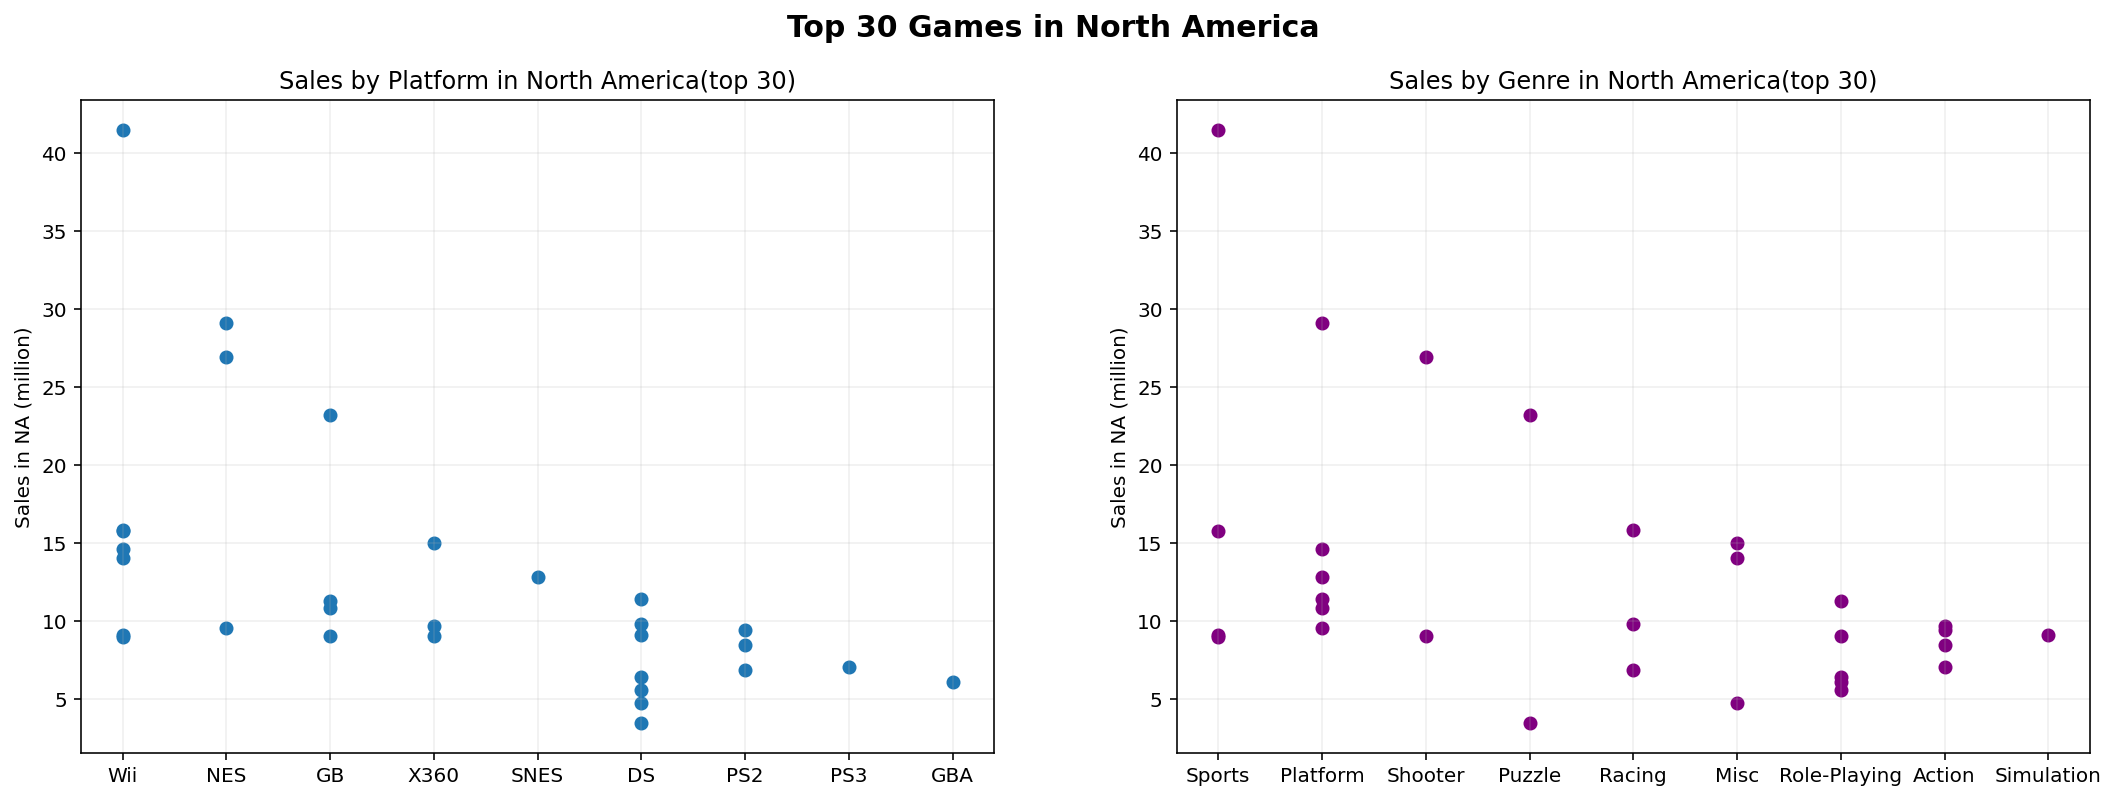

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

ax[0].scatter(df_top_NA['Platform'], df_top_NA['NA_Sales(M)'])
ax[1].scatter(df_top_NA['Genre'], df_top_NA['NA_Sales(M)'], color = 'purple')
ax[0].set_title('Sales by Platform in North America(top 30)')
ax[1].set_title('Sales by Genre in North America(top 30)')

for i in range(0, 2) :
  ax[i].grid(alpha= .2)
  ax[i].set_ylabel('Sales in NA (million)')
  
plt.suptitle('Top 30 Games in North America', fontsize = 15, weight = 'bold')

plt.show();

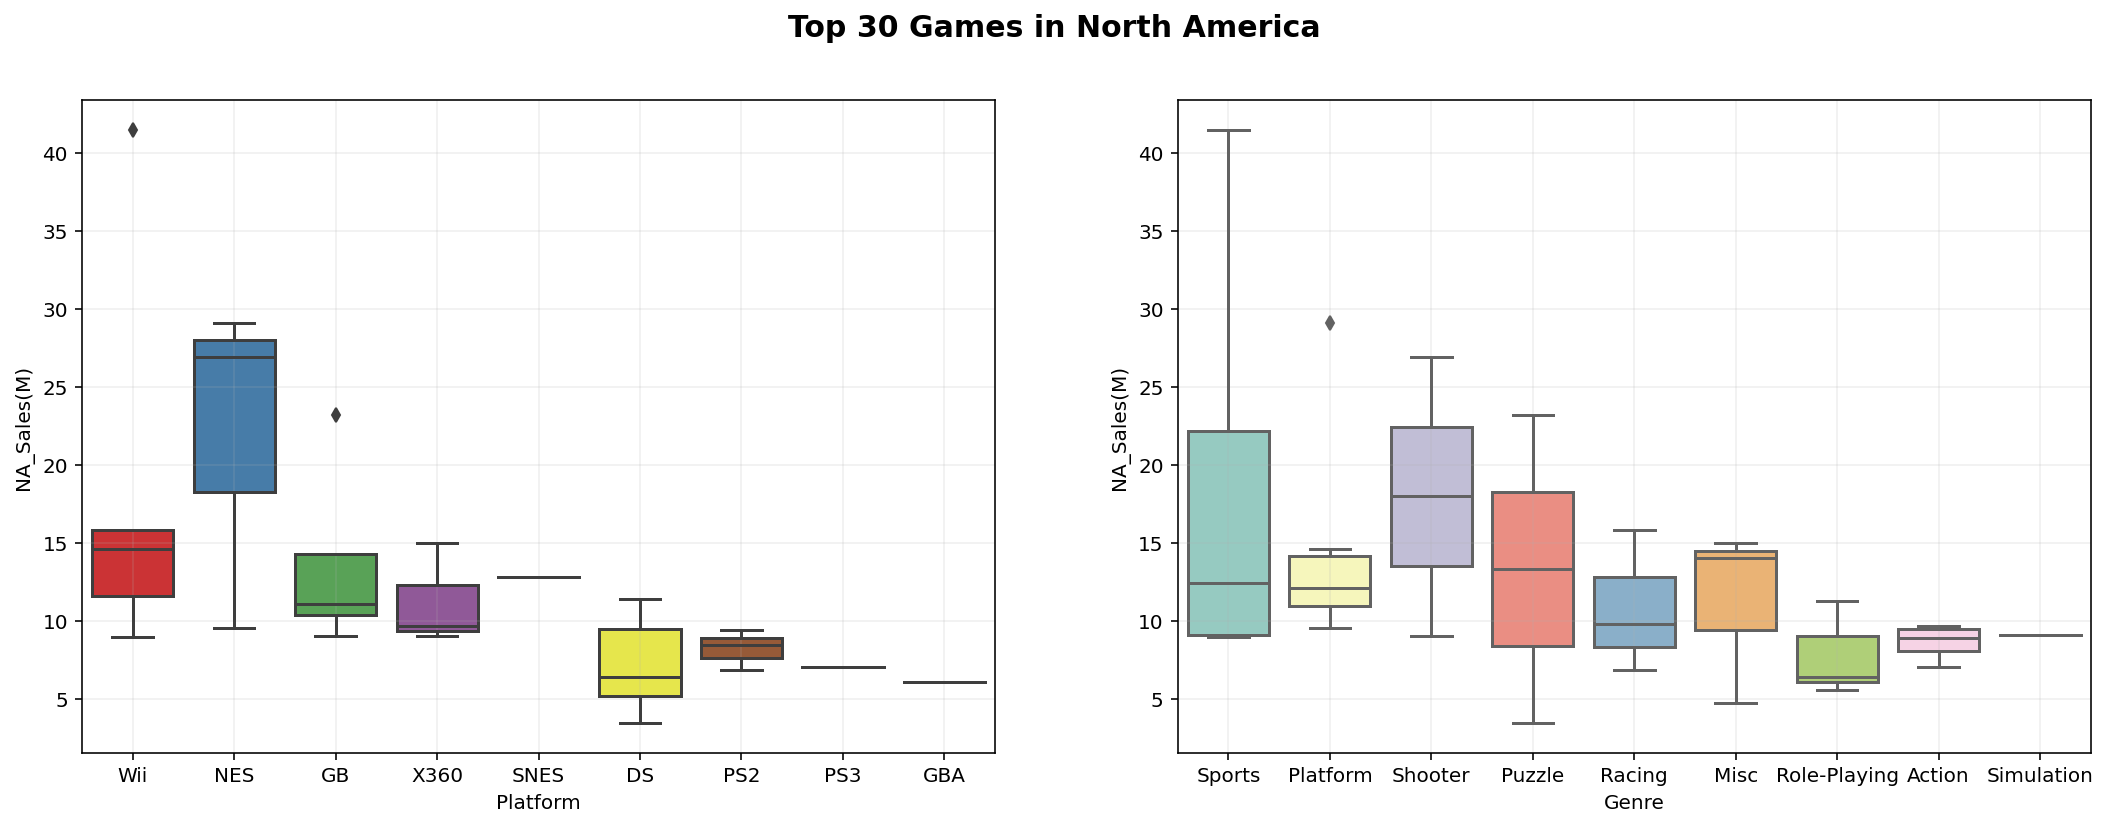

In [ ]:
f, axes = plt.subplots(1, 2, figsize = (18, 6))
sns.boxplot(x = df_top_NA['Platform'], y = df_top_NA['NA_Sales(M)'], ax = axes[0], palette = 'Set1')
sns.boxplot(x = df_top_NA['Genre'], y = df_top_NA['NA_Sales(M)'], ax = axes[1], palette = 'Set3')
plt.suptitle('Top 30 Games in North America', fontsize = 15, weight = 'bold')

for i in range(0, 2) :
  axes[i].grid(alpha = .2)

plt.show();

지역별 매출액을 합한 전체 매출액을 기준으로 top 30을 추출하였다.

이후 타겟 지역을 확인하기 위해 top30 데이터 내에서 전체 매출액과 각 지역별 매출액의 상관관계를 확인하고,

북미 지역의 매출이 전체 매출에 가장 큰 영향을 끼치는 것을 확인하였다.

다음 과정으로 북미 지역에서 선호하는 플랫폼 및 장르를 분석하기 위해 시각화를 진행하였다.

시각화 결과를 살펴보면,


1. 우선 플랫폼 부분은 출시 연도를 고려해야 한다.

   NES, GB는 박스플롯에서 꽤 높은 수치를 가지지만 오래된 플랫폼이므로 제외하고,

   Wii, X360, PS 플랫폼을 사용하는 게임 설계를 목표로 잡을 수 있을 것이다. 


2. top 30의 장르별 매출을 살펴보기 전 위에서 분석하였던 지역별 선호 장르에서 
   
   북미지역은 sports, shooter, racing, action 등 액티브한 게임을 선호하는 경향이 있음을  알 수 있다.

   이를 바탕으로 박스플롯 차트를 보면 sports 혹은 shooter 장르의 매출이 높은 것으로 확인되므로 이를  고려하여 신작 설계를 해볼 수 있을 것이다. 
   
   (아래 참조)




   

In [ ]:
import plotly.express as px
px.scatter(df_top_NA, x = 'Year', y = 'NA_Sales(M)', color = 'Genre', title = {'text' : 'Genre in NA', 'x' : 0.45, 'y' : 0.9})

In [ ]:
px.scatter(df_top_NA, x = 'Year', y = 'NA_Sales(M)', color = 'Platform', title = {'text' : 'Platform in NA', 'x' : 0.45, 'y' : 0.9})



---



# Q4. 게임 제작 회사(publisher)의 국가가 매출과 연관이 있을까 ?
- 분석방향 :
  
  1. 매출 상위 30개 회사들의 국가를 조사
  2. 전체 데이터셋에 국가 feature 추가
  3. 매출 상위 30개 게임을 제작한 회사에 해당되지 않는 데이터 드랍 
  4. 추려진 데이터를 바탕으로 k-means clustering 실시 (k = 2, 국가 클러스터와 비교를 위해)
  5. Accuracy 측정 : Country Vs. K-means clustering

In [ ]:
#게임 제작회사(publisher)의 국가가 매출과 연관이 있을까
print('매출 상위 30개 회사')
print(df_top['Publisher'].unique())
df_top.head()

매출 상위 30개 회사
['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision']


,Name,Platform,Genre,Publisher,Year,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales
0,Wii Sports,Wii,Sports,Nintendo,2006,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,Platform,Nintendo,1985,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,Racing,Nintendo,2008,15.85,12.88,3.79,3.31,35.83
3,Wii Sports Resort,Wii,Sports,Nintendo,2009,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,Role-Playing,Nintendo,1996,11.27,8.89,10.22,1.00,31.38


In [ ]:
#매출 상위 30개 해당 회사들의 국가를 추려서 전체 데이터셋에 국가 feature 추가
df.loc[(df['Publisher'] == 'Nintendo') | (df['Publisher'] == 'Sony Computer Entertainment'), 'Company Origin'] = 'Japan'
df.loc[(df['Publisher'] == 'Microsoft Game Studios') | (df['Publisher'] == 'Take-Two Interactive') 
       | (df['Publisher'] == 'Activision'), 'Company Origin'] = 'USA'

#매출 상위 30개에 해당되지 않는 회사는 드랍
df2 = df.dropna().reset_index().drop(columns = 'index')
print(df2.shape)
df2.head()

(2934, 11)


,Name,Platform,Genre,Publisher,Year_2,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales,Company Origin
0,Rise of Nations,PC,Strategy,Microsoft Game Studios,03,0.01,0.02,0.00,0.01,0.04,USA
1,Ghost in the Shell,PS,Simulation,Sony Computer Entertainment,97,0.06,0.04,0.00,0.01,0.11,Japan
2,Cabela's Dangerous Hunts 2,XB,Sports,Activision,05,0.08,0.02,0.00,0.00,0.10,USA
3,Project Sylpheed: Arc of Deception,X360,Shooter,Microsoft Game Studios,06,0.12,0.01,0.02,0.01,0.16,USA
4,Mario & Luigi: Paper Jam & Mario Kart 7 Double...,3DS,Misc,Nintendo,15,0.00,0.00,0.01,0.00,0.01,Japan


In [ ]:
#추려진 데이터를 바탕으로 k means clustering 실시
df2_sales = df2[['NA_Sales(M)', 'EU_Sales(M)', 'JP_Sales(M)', 'Other_Sales(M)']]
df2_sales.head()

,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M)
0,0.01,0.02,0.00,0.01
1,0.06,0.04,0.00,0.01
2,0.08,0.02,0.00,0.00
3,0.12,0.01,0.02,0.01
4,0.00,0.00,0.01,0.00


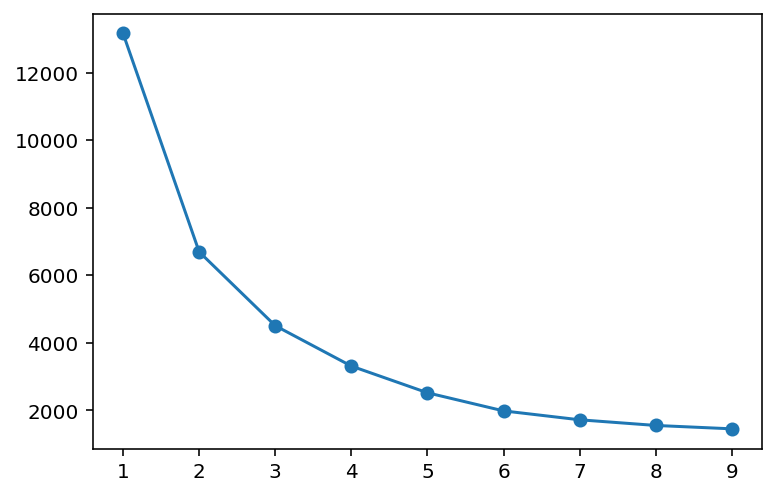

In [ ]:
from sklearn.cluster import KMeans

# 클러스터링의 목적 : 게임 제작 국가별 클러스터링이 되는지 확인하는 것
# 아래 elbow method 결과, 6개 이상의 클러스터를 설정해야 효율적이라고 확인되지만 분석 목적은 2개의 클러스터가 필요하므로 무시
squared_distances = []

for k in range(1, 10) :
  km = KMeans(n_clusters = k)
  km = km.fit(df2_sales)
  squared_distances.append(km.inertia_)

plt.plot(range(1, 10), squared_distances, marker = 'o')
plt.show();

In [ ]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(df2_sales)
labels = kmeans.labels_
df2['Cluster'] = labels
print(df2.shape)
df2.head()

(2934, 12)


,Name,Platform,Genre,Publisher,Year_2,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales,Company Origin,Cluster
0,Rise of Nations,PC,Strategy,Microsoft Game Studios,03,0.01,0.02,0.00,0.01,0.04,USA,0
1,Ghost in the Shell,PS,Simulation,Sony Computer Entertainment,97,0.06,0.04,0.00,0.01,0.11,Japan,0
2,Cabela's Dangerous Hunts 2,XB,Sports,Activision,05,0.08,0.02,0.00,0.00,0.10,USA,0
3,Project Sylpheed: Arc of Deception,X360,Shooter,Microsoft Game Studios,06,0.12,0.01,0.02,0.01,0.16,USA,0
4,Mario & Luigi: Paper Jam & Mario Kart 7 Double...,3DS,Misc,Nintendo,15,0.00,0.00,0.01,0.00,0.01,Japan,0


In [ ]:
#accuracy 측정

country_cluster = pd.DataFrame(df2['Company Origin'])
country_cluster['new_cluster'] = df2['Cluster']
country_cluster['Company Origin'] = country_cluster['Company Origin'].replace('USA', 0)
country_cluster['Company Origin'] = country_cluster['Company Origin'].replace('Japan', 1)

country_cluster

,Company Origin,new_cluster
0,0,0
1,1,0
2,0,0
3,0,0
4,1,0
...,...,...
2929,0,0
2930,1,0
2931,1,0
2932,0,0


In [ ]:
T_F = country_cluster['Company Origin'] == country_cluster['new_cluster']
print('US = 0, JP = 1 : accuracy is', (T_F.sum() / T_F.count()) * 100, '%')

US = 0, JP = 1 : accuracy is 53.71506475800955 %


In [ ]:
country_cluster = pd.DataFrame(df2['Company Origin'])
country_cluster['new_cluster'] = df2['Cluster']
country_cluster['Company Origin'] = country_cluster['Company Origin'].replace('USA', 1)
country_cluster['Company Origin'] = country_cluster['Company Origin'].replace('Japan', 0)

T_F = country_cluster['Company Origin'] == country_cluster['new_cluster']
print('US = 1, JP = 0 : accuracy is', (T_F.sum() / T_F.count()) * 100, '%')

US = 1, JP = 0 : accuracy is 46.28493524199045 %


- **결론** : 
  
  k-means clustering 을 실시해서 얻은 군집과 추가 조사를 통해 얻은 Country가 비슷한 군집을 형성하지 않는다.

  고로 게임 제작 회사의 국가에 따라 매출 현황이 크게 달라지지 않는다고 볼 수 있음



---





# Q5. 게임 제작사의 게임 출시 횟수와 평균 매출액 사이 연관이 있을까?

In [ ]:
df

,Name,Platform,Genre,Publisher,Year_2,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales,Company Origin
0,Candace Kane's Candy Factory,DS,Action,Destineer,08,0.04,0.00,0.00,0.00,0.04,NaN
1,The Munchables,Wii,Action,Namco Bandai Games,09,0.17,0.00,0.00,0.01,0.18,NaN
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,Adventure,Alchemist,10,0.00,0.00,0.02,0.00,0.02,NaN
3,Deal or No Deal: Special Edition,DS,Misc,Zoo Games,10,0.04,0.00,0.00,0.00,0.04,NaN
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,Platform,D3Publisher,10,0.12,0.09,0.00,0.04,0.25,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16272,Ice Age 2: The Meltdown,GC,Platform,Vivendi Games,06,0.15,0.04,0.00,0.01,0.20,NaN
16273,Rainbow Islands: Revolution,PSP,Action,Rising Star Games,05,0.01,0.00,0.00,0.00,0.01,NaN
16274,NBA 2K16,PS3,Sports,Take-Two Interactive,15,0.44,0.19,0.03,0.13,0.79,USA
16275,Toukiden: The Age of Demons,PSV,Action,Tecmo Koei,13,0.05,0.05,0.25,0.03,0.38,NaN


In [ ]:
# 게임제작사별 평균 매출액 데이터 프래임 생성
merge_left = df.groupby('Publisher').mean().reset_index().sort_values('Publisher', ascending = True)
merge_left 

# 제작사별 게임 출시 횟수 데이터프레임 생성
publisher_vals = df.Publisher.value_counts() 
merge_right = pd.DataFrame(publisher_vals).reset_index().rename(columns = {'index' : 'Publisher', 'Publisher' : 'Count'})
merge_right.sort_values('Publisher')
merge_right

 # merge를 사용하여 제작사별 평균 매출액, 출시횟수 데이터프레임 생성
count_sales = merge_left.merge(merge_right, how = 'inner')
print(count_sales.shape)
count_sales.head()

(576, 7)


,Publisher,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales,Count
0,10TACLE Studios,0.023333,0.013333,0.0,0.000000,0.036667,3
1,1C Company,0.003333,0.023333,0.0,0.006667,0.033333,3
2,20th Century Fox Video Games,0.364000,0.020000,0.0,0.002000,0.386000,5
3,2D Boy,0.000000,0.030000,0.0,0.010000,0.040000,1
4,3DO,0.180000,0.084444,0.0,0.017500,0.281944,36


In [ ]:
#whloe_sales & count 연관이 있을까?
#정규화 및 t test 실시

from sklearn.preprocessing import MinMaxScaler

df_for_ttest = pd.DataFrame(MinMaxScaler().fit_transform(count_sales[['whole_sales', 'Count']]), columns = {'whole_sales', 'count'}, index = count_sales['Publisher'])
df_for_ttest = df_for_ttest.reset_index()
print('귀무가설 : 전체 매출액과 출시횟수의 평균값이 같을 것이다.')
print('대안가설 : 전체 매출액과 출시횟수의 평균값이 같지 않을 것이다.')
df_for_ttest

귀무가설 : 전체 매출액과 출시횟수의 평균값이 같을 것이다.
대안가설 : 전체 매출액과 출시횟수의 평균값이 같지 않을 것이다.


,Publisher,whole_sales,count
0,10TACLE Studios,0.006410,0.001503
1,1C Company,0.005609,0.001503
2,20th Century Fox Video Games,0.090385,0.003005
3,2D Boy,0.007212,0.000000
4,3DO,0.065371,0.026296
...,...,...,...
571,id Software,0.002404,0.000000
572,imageepoch Inc.,0.002404,0.000751
573,inXile Entertainment,0.019231,0.000000
574,"mixi, Inc",0.204327,0.000000


In [ ]:
from scipy import stats

statistic, pvalue = stats.ttest_ind(df_for_ttest['whole_sales'], df_for_ttest['count'])
print('T-statistic :', statistic, '\nP-value :', pvalue)
print('신뢰수준 95%에서 p-value 값이 0에 가까우므로 귀무가설을 기각할 충분한 근거가 있다.')

T-statistic : 5.290785172280372 
P-value : 1.457366874646558e-07
신뢰수준 95%에서 p-value 값이 0에 가까우므로 귀무가설을 기각할 충분한 근거가 있다.


In [ ]:
#t test 이후 실제로 sales & count 의 관계를 알아보는 과정
# 상관계수 0.224
count_sales['whole_sales'].corr(count_sales['Count'])

0.2239388107528528

In [ ]:
#그럼 unit sales가 높은 publisher는 어디일까?
c = count_sales.drop(columns = count_sales.columns[1:5])
c['unit_sales(sales/count)'] = c['whole_sales'] / c['Count']
c = c.sort_values('unit_sales(sales/count)', ascending = False).reset_index().drop(columns = 'index').head(30)
print(c.shape)
c.head() #unit sales top30

(30, 4)


,Publisher,whole_sales,Count,unit_sales(sales/count)
0,Palcom,4.17,1,4.17
1,UEP Systems,2.26,1,2.26
2,Valve,1.73,1,1.73
3,Hello Games,1.60,1,1.60
4,Westwood Studios,1.55,1,1.55


In [ ]:
#전체 데이터에서 unit sales top30 회사를 찾음
c_p_lst = c.Publisher.values.tolist()
find_vals = df[df['Publisher'].str.contains('|'.join(c_p_lst))] #여러개의 value를 찾기 위해 str.contains 사용하는 과정
find_vals = find_vals.reset_index().drop(columns = 'index')
print(find_vals.shape)
find_vals.head()

(50, 11)


,Name,Platform,Genre,Publisher,Year_2,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),whole_sales,Company Origin
0,Sesame Street: Elmo's Letter Adventure,N64,Misc,NewKidCo,99,0.14,0.04,0.00,0.00,0.18,NaN
1,Teenage Mutant Ninja Turtles,NES,Action,Palcom,89,3.38,0.44,0.31,0.04,4.17,NaN
2,The Lord of the Rings: The Fellowship of the Ring,PS2,Action,Black Label Games,02,0.59,0.46,0.00,0.15,1.20,NaN
3,Sesame Street: Elmo's Number Journey,PS,Misc,NewKidCo,98,0.13,0.09,0.00,0.02,0.24,NaN
4,Zoop,PS,Puzzle,MediaQuest,95,0.03,0.02,0.00,0.00,0.05,NaN


In [ ]:
# unit sales 가 높은 제작사의 게임들을 추출하여 새로운 데이터프레임 생성
# unit sales top30 회사에서 만든 게임들을 추출한 데이터셋
count_sales_top = c.merge(find_vals, how = 'inner', on = 'Publisher').drop(columns = ['whole_sales_x', 'Company Origin']).set_index('Name').reset_index()
count_sales_top = count_sales_top.rename(columns = {'unit_sales(sales/count)' : 'unit_sales', 'Year_2' : 'Year', 'whole_sales_y' : 'sales_total'})
count_sales_top = count_sales_top[['Publisher', 'Name',	'Platform',	'Genre',	'Year',	'NA_Sales(M)', 'EU_Sales(M)',	'JP_Sales(M)', 'Other_Sales(M)', 'sales_total', 'Count', 'unit_sales']]
print(count_sales_top.shape)
count_sales_top.head()

# 필요하다면 아래 데이터를 사용해 추가 분석을 시도해 볼 수 있을 것이다.
# 해당 제작사를 모티브로 많은 게임을 출시하지 않고, 어떻게 보다 효율적인 게임을 제작하여 높은 매출을 올릴 수 있을 지 전략적으로 접근해 볼 수 있음 

(39, 12)


,Publisher,Name,Platform,Genre,Year,NA_Sales(M),EU_Sales(M),JP_Sales(M),Other_Sales(M),sales_total,Count,unit_sales
0,Palcom,Teenage Mutant Ninja Turtles,NES,Action,89,3.38,0.44,0.31,0.04,4.17,1,4.17
1,UEP Systems,Cool Boarders 2,PS,Sports,97,1.52,0.46,0.20,0.08,2.26,1,2.26
2,Valve,Portal 2,PS3,Shooter,11,0.83,0.63,0.02,0.25,1.73,1,1.73
3,Hello Games,No Man's Sky,PS4,Action,16,0.58,0.74,0.02,0.26,1.60,1,1.60
4,Westwood Studios,Command & Conquer: Tiberian Sun,PC,Strategy,99,1.55,0.00,0.00,0.00,1.55,1,1.55


- **결론** :

  1. 게임 제작사의 게임 출시 횟수와 평균 매출액 사이 연관성을 확인하기 위해

     필요 데이터를 추출하고 정규화 및 t-test 검정을 실시 하였다.

  2. 테스트 결과 두 feature 사이에는 관계가 없을 것이라 확인 되었으며,

     상관계수 또한 0.224로 매우 낮은 수치가 나왔음을 알 수 있다.

  3. 그렇다면 unit sales(게임 출시 수 당 매출액)이 높은 회사를 확인 해보고자 과정을 진행하였다.

  4. unit sales가 높은 회사 top30을 확인하였으며,

     이 회사들을 모티브로 하여 거대 게임 제작사와 같이 많은 게임을 출시하지 않고,

     높은 매출을 올릴 수 있을 지 다음 분기 전략을 구성해 볼 수 있을 것이다.